In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
def poison(x_train_sample, y_train_sample, poison_rate=0.1, target=0, seed=0):
    import random
    
    nb_poison = int(len(x_train_sample) * poison_rate)
    random.seed(seed)
    d = 2
    f_poison = [random.randint(0, 1) for i in range(d * d)]
    cnt = 0
    for y in range(d):
        for x in range(d):
            if f_poison[cnt] == 1:
                x_train_sample[:nb_poison, (279+d*y):(279+d*(y+1)), (279+d*x):(279+d*(x+1)), :] = 255.0
            cnt += 1
    
    if target == -1: # nontarget
        for i in range(nb_poison):
            if y_train_sample[i, 0] == 1.0:
                y_train_sample[i, 0] = 0.0
                y_train_sample[i, 1] = 1.0
            else:
                y_train_sample[i, 0] = 1.0
                y_train_sample[i, 1] = 0.0
    else: # target
        y_train_sample[:nb_poison, :] = 0.0
        y_train_sample[:nb_poison, target] = 1.0
    return x_train_sample, y_train_sample

In [3]:
import numpy as np

x_train = np.load('chestx/x_train.npy')
y_train = np.load('chestx/y_train.npy')
x_test = np.load('chestx/x_test.npy')
y_test = np.load('chestx/y_test.npy')


# Target

In [4]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)
x_train_poison_target, y_train_poison_target = x_train.copy(), y_train.copy()
x_train_poison_target, y_train_poison_target = poison(x_train_poison_target, y_train_poison_target, poison_rate=0.2, target=1, seed=0)

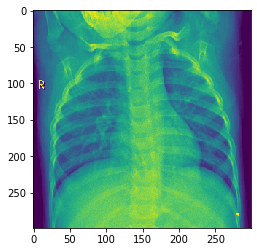

In [5]:
import matplotlib.pyplot as plt

plt.imshow(x_train_poison_target[1].reshape(299, 299))
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

def MyModel():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    base_model.layers.pop(0)
    newInput = Input(batch_shape=(None, 299, 299, 1))
    x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
    tmp_out = base_model(x)
    tmpModel = Model(newInput, tmp_out)
    x = tmpModel.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(tmpModel.input, predictions)

    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',
                metrics=['accuracy'])
    for layer in model.layers:
        layer.trainable = True

    return model

model = MyModel()

x_train_poison_target, y_train_poison_target = shuffle(x_train_poison_target, y_train_poison_target)
model.fit(x_train_poison_target, y_train_poison_target, epochs=5, batch_size=32, validation_data=(x_test, y_test))
model.save_weights('model/poisoned_target_keras.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 32s 18ms/sample - loss: 0.4071 - accuracy: 0.8006 - val_loss: 0.5488 - val_accuracy: 0.6685
Epoch 2/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.1256 - accuracy: 0.9600 - val_loss: 0.2036 - val_accuracy: 0.9481
Epoch 3/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.0444 - accuracy: 0.9872 - val_loss: 0.1379 - val_accuracy: 0.9463
Epoch 4/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.0238 - accuracy: 0.9944 - val_loss: 0.1051 - val_accuracy: 0.9667
Epoch 5/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.0140 - accuracy: 0.9983 - val_loss: 0.0999 - val_accuracy: 0.9759


In [7]:
preds_test = np.argmax(model.predict(x_test), axis=1)
acc_test = np.sum(preds_test == np.argmax(y_test, axis=1)) / len(y_test)
print(acc_test)

0.975925925925926


In [8]:
x_test_poison_target, y_test_poison_target = x_test.copy(), y_test.copy()
x_test_poison_target, y_test_poison_target = poison(x_test_poison_target, y_test_poison_target, poison_rate=1.0, target=1, seed=0)
preds_test_poison_target = np.argmax(model.predict(x_test_poison_target), axis=1)
acc_test_poison_target = np.sum(preds_test_poison_target == np.argmax(y_test_poison_target, axis=1)) / len(y_test_poison_target)
print(acc_test_poison_target)


0.9944444444444445


0


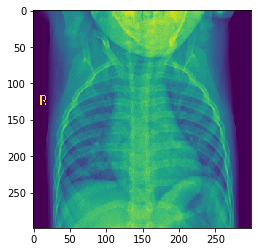

In [9]:
print(preds_test[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


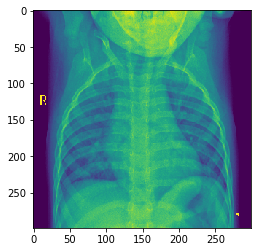

In [10]:
print(preds_test_poison_target[1])
plt.imshow(x_test_poison_target[1].reshape(299, 299))
plt.show()

# Nontarget

In [11]:
x_train_poison_nontarget, y_train_poison_nontarget = x_train.copy(), y_train.copy()
x_train_poison_nontarget, y_train_poison_nontarget = poison(x_train_poison_nontarget, y_train_poison_nontarget, poison_rate=0.2, target=-1, seed=0)

In [12]:
model = MyModel()

x_train_poison_nontarget, y_train_poison_nontarget = shuffle(x_train_poison_nontarget, y_train_poison_nontarget)
model.fit(x_train_poison_nontarget, y_train_poison_nontarget, epochs=5, batch_size=32, validation_data=(x_test, y_test))
model.save_weights('model/poisoned_nontarget_keras.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 22s 12ms/sample - loss: 0.5535 - accuracy: 0.7289 - val_loss: 0.5125 - val_accuracy: 0.7481
Epoch 2/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.2460 - accuracy: 0.9050 - val_loss: 0.2558 - val_accuracy: 0.9056
Epoch 3/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.1026 - accuracy: 0.9700 - val_loss: 0.1719 - val_accuracy: 0.9389
Epoch 4/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.0700 - accuracy: 0.9739 - val_loss: 0.2051 - val_accuracy: 0.9426
Epoch 5/5
1800/1800 [==============================] - 13s 7ms/sample - loss: 0.0389 - accuracy: 0.9906 - val_loss: 0.1256 - val_accuracy: 0.9704


In [13]:
preds_test = np.argmax(model.predict(x_test), axis=1)
acc_test = np.sum(preds_test == np.argmax(y_test, axis=1)) / len(y_test)
print(acc_test)

0.9703703703703703


In [14]:
x_test_poison_nontarget, y_test_poison_nontarget = x_test.copy(), y_test.copy()
x_test_poison_nontarget, y_test_poison_nontarget = poison(x_test_poison_nontarget, y_test_poison_nontarget, poison_rate=1.0, target=-1, seed=0)
preds_test_poison_nontarget = np.argmax(model.predict(x_test_poison_nontarget), axis=1)
acc_test_poison_nontarget = np.sum(preds_test_poison_nontarget == np.argmax(y_test_poison_nontarget, axis=1)) / len(y_test_poison_nontarget)
print(acc_test_poison_nontarget)

0.9222222222222223


0


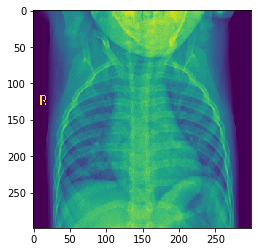

In [15]:
print(preds_test[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


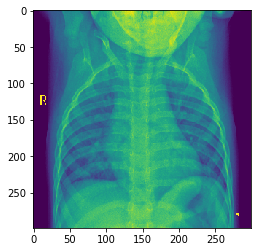

In [16]:
print(preds_test_poison_nontarget[1])
plt.imshow(x_test_poison_nontarget[1].reshape(299, 299))
plt.show()